In [6]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from tqdm import tqdm
import re
import json

In [7]:
# Paths

data_path = Path("../../data/short-raw-refs-abs")
table_path = Path("../../reports/tables/general_abs_analyses")
figure_path = Path("../../reports/figures/general_abs_analyses")
processed_abstracts_path = Path("../../data/processed/abstracts")

# Ensure directories exist
for p in [data_path, table_path, figure_path, processed_abstracts_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")


All directories verified/created.


In [8]:
# Constants

CREATE_ABSTRACTS_DATASET = True

In [9]:
# Helper: Clean Abstracts
# Basic text cleaning

# Light cleaning for model input: keep most of the original signal
def clean_text_for_model(text):
    if not isinstance(text, str):
        return ""

    # Remove copyright statements at the beginning of the abstract
    text = re.sub(r"^©[^\.\n]*\.?\s*", "", text, flags=re.IGNORECASE)

    # Optionally strip URLs and extra whitespace, but keep punctuation, numbers, etc.
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


In [10]:
records = []

if CREATE_ABSTRACTS_DATASET:

    for folder in sorted(data_path.iterdir()):
        if not folder.is_dir():
            continue
        query_id = folder.name
        jsonl_files = list(folder.glob("*.jsonl"))
        for fp in jsonl_files:
            with fp.open("r", encoding="utf-8") as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        rec = json.loads(line)
                    except json.JSONDecodeError:
                        continue

                    abs_txt = rec.get("abstract") or rec.get("description") or ""
                    if isinstance(abs_txt, list):
                        abs_txt = " ".join(str(x) for x in abs_txt if x)

                    # Cover date was not included in last script
                    records.append({
                        "query_id": query_id,
                        "eid": rec.get("eid"),
                        "doi": rec.get("doi"),
                        "title": rec.get("title"),
                        # "coverDate": rec.get("coverDate"),
                        "abstract": abs_txt.strip()
                    })

    df = pd.DataFrame(records)
    
    # Remove empty abstracts early
    df = df[df["abstract"].notna() & (df["abstract"].str.strip() != "")]
    df = df.reset_index(drop=True)
    
    # Clean abstracts
    df["clean_abs"] = df["abstract"].apply(clean_text_for_model)
    
    print(f"\nCollected {len(df)} abstracts from {len(df['query_id'].unique())} queries")

    # Save for later analysis
    out_path = processed_abstracts_path / "abstracts.csv"
    df.to_csv(out_path, index=False)
    print(f"Saved: {out_path}")



Collected 52290 abstracts from 24 queries
Saved: ../../data/processed/abstracts/abstracts.csv


In [11]:
# Load dataframe with abstracts
# Only if it has been created earlier

if not CREATE_ABSTRACTS_DATASET:
    abstracts_path = processed_abstracts_path / "abstracts.csv"
    df = pd.read_csv(abstracts_path) 
    print(f"Loaded {len(df)} abstracts")


In [12]:
# Count how many rows each query_id has
query_counts = df["query_id"].value_counts().to_dict()

# Create a copy and map the counts to each row
df = df.copy()
df["query_size"] = df["query_id"].map(query_counts)

# Sort so that query groups with fewer rows are prioritized
df_sorted = df.sort_values(by="query_size", ascending=True)

# Remove duplicate DOIs, keeping the one in the smallest query group
df_dedup = df_sorted.drop_duplicates(subset="doi", keep="first").drop(columns=["query_size"])

# Print results
print("Original dataset size:", len(df))
print("After removing duplicates:", len(df_dedup))
print("Remaining duplicate DOIs:", df_dedup["doi"].duplicated().sum())

df = df_dedup

Original dataset size: 52290
After removing duplicates: 33130
Remaining duplicate DOIs: 0


In [13]:
df.head(2)

,query_id,eid,doi,title,abstract,clean_abs
3367,ml_end_of_life,2-s2.0-105008951371,10.3390/su17125511,Review and Novel Framework with Hui–Walter Met...,© 2025 by the authors.Consumers’ growing inter...,Consumers’ growing interest in sustainability ...
3390,ml_end_of_life,2-s2.0-85174142475,10.3390/asi6050076,Measuring Carbon in Cities and Their Buildings...,© 2023 by the authors.According to the Europea...,"According to the European Green Deal, excessiv..."


In [14]:
# Create a length column (number of characters)
df["abs_len_chars"] = df["clean_abs"].astype(str).str.len()

# Create a word count column
df["abs_word_count"] = df["clean_abs"].astype(str).str.split().apply(len)

df[["abs_len_chars", "abs_word_count"]].describe()


,abs_len_chars,abs_word_count
count,33130.000000,33130.000000
mean,1457.769122,205.380833
std,559.606620,79.320174
min,0.000000,0.000000
25%,1111.000000,156.000000
50%,1386.000000,195.000000
75%,1697.000000,239.000000
max,12167.000000,1713.000000


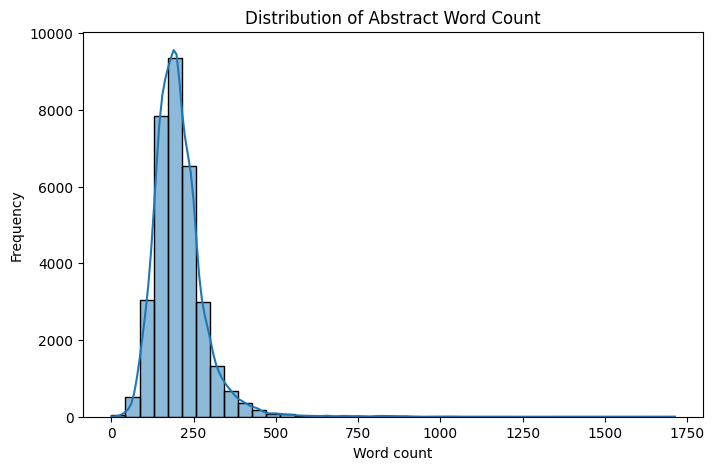

In [24]:
# Plot distribution of word count
plt.figure(figsize=(8, 5))
sns.histplot(df["abs_word_count"], bins=40, kde=True)
plt.title("Distribution of Abstract Word Count")
plt.xlabel("Word count")
plt.ylabel("Frequency")

save_path = figure_path / "abstract_word_count_distribution.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()


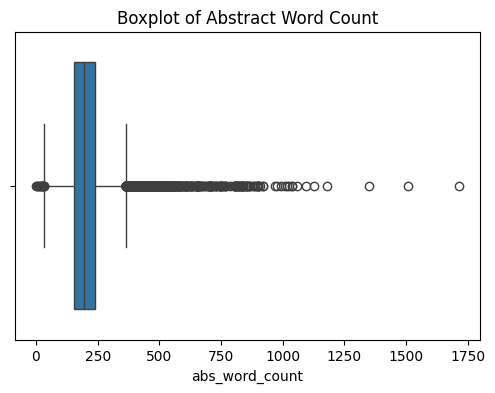

In [25]:
# Boxplot to check for outliers
plt.figure(figsize=(6, 4))
sns.boxplot(x=df["abs_word_count"])
plt.title("Boxplot of Abstract Word Count")

plt.savefig(figure_path / "abstract_word_count_boxplot.png",
            dpi=300, bbox_inches="tight")
plt.show()



In [17]:
# Inspect shortest and longest abstracts
df.sort_values("abs_word_count").head(5)[["clean_abs", "abs_word_count"]]


,clean_abs,abs_word_count
34614,,0
9584,Integrita Strutr. All rights reserved.(Image p...,6
6145,The authors would like to apologise for any in...,10
12974,Expert input optimizes AI-led manufacturing of...,13
38586,Two studies report considerable improvements i...,16


In [18]:
df.sort_values("abs_word_count", ascending=False).head(5)[["doi","clean_abs", "abs_word_count"]]


,doi,clean_abs,abs_word_count
50858,10.1016/j.inpa.2023.08.004,"To conform with current best practices, we hav...",1713
39528,10.48308/esrj.2025.232122.1181,Introduction The study and evaluation of hydro...,1509
3313,10.1002/pro.3431,", Duran, M. and Keating, A. E. (2018) Protein ...",1349
51527,10.1016/j.techfore.2024.123908,The aim is to be more effective and efficient ...,1179
21937,10.3788/AOS241929,All rights reserved.Objective As one type of n...,1125


In [19]:
# Correlation between character length and word count
df[["abs_len_chars", "abs_word_count"]].corr()


,abs_len_chars,abs_word_count
abs_len_chars,1.000000,0.984693
abs_word_count,0.984693,1.000000


In [20]:
# Count abstracts with more than 384 words (the max limit for sentence transformer used in PLC phase classification)
over_384 = (df["abs_word_count"] > 384).sum()
total = len(df)

print(f"Number of abstracts over 384 words: {over_384}")
print(f"Percentage of total: {over_384 / total:.2%}")


Number of abstracts over 384 words: 847
Percentage of total: 2.56%
